In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
#import wandb
#wandb.init(project="Plant Disease")
import torchvision
from torchvision import transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive

/content/drive


In [ ]:
%cd MyDrive

/content/drive/MyDrive


In [ ]:
path = '/content/drive/MyDrive/plant_disease_centernet/data.zip'
from zipfile import ZipFile
with ZipFile(path, 'r') as aip:
    aip.printdir()
    print('Extracting all the files now.')
    aip.extractall()
    print('Done!')

File Name                                             Modified             Size
train/Faske%20Southern%20rust%20of%20corn_jpg.rf.016116db58617610bb259b2965f41589.jpg 2020-03-09 13:30:34        30487
train/Slide1_preview_jpg.rf.00f57cfc188631c10e10e2b93a38d296.jpg 2020-03-09 13:30:34        24261
train/2017-08-27%2B-%2BLate%2BBlight%2Bon%2BGypsy%2B1_jpg.rf.00584c9d14b6fda3086f9a482675d610.jpg 2020-03-09 13:30:34        35160
train/Apple-Scab-image-02_jpg.rf.00cbc9a108dbdaadf4232b5392e3d3c8.jpg 2020-03-09 13:30:34        29887
train/24154194959_fd4b42edde_b_jpg.rf.0012f9978a300c5635840700fa784280.jpg 2020-03-09 13:30:34        27818
train/2-3%20Gray%20leaf%20spot%20BRUCE_jpg.rf.0040c2e382cf11216938e6f49b7d65ed.jpg 2020-03-09 13:30:34        32519
train/Septoria_tomato_Margaret%20B_p8170755_0002_25004_jpg.rf.00ddfef2668a53da256f207f9b844782.jpg 2020-03-09 13:30:34        44843
train/d-to-tylv-fo005-14496A31BE70553130A_jpg.rf.017e4558f1b4baeadc32a13beb178a6e.jpg 2020-03-09 13:30:34        

In [ ]:
!mv ./test/_annotations.csv ./test.csv
!mv ./train/_annotations.csv ./train.csv

In [ ]:
##configuration settings 

MODEL_SCALE = 1
batch_size = 2
model_name = "resnet18"
TRAIN = True 
DIR_INPUT = '/content/drive/MyDrive/'
DIR_TRAIN = '/content/drive/MyDrive/test'
DIR_TEST = '/content/drive/MyDrive/train'
MODEL_PATH = ""
input_size = 128
IN_SCALE = 416//input_size 

In [ ]:
##defining pooling operation
def pool(data):
    stride = 3
    for y in np.arange(1,data.shape[1]-1, stride):
        for x in np.arange(1, data.shape[0]-1, stride):
            a_2d = data[x-1:x+2, y-1:y+2]
            max = np.asarray(np.unravel_index(np.argmax(a_2d), a_2d.shape))            
            for c1 in range(3):
                for c2 in range(3):
                    if not (c1== max[0] and c2 == max[1]):
                        data[x+c1-1, y+c2-1] = -1
    return data

In [ ]:
## Function to normalize the image
class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image

In [ ]:
### custom pytorch dataloader to load our training dataset
class WheatDataset(torch.utils.data.Dataset):
    def __init__(self, img_id, labels, transform=None):
        self.img_id = img_id
        self.labels = labels
        if transform:
            self.transform = transform
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
      try:
        img = cv2.imread(os.path.join(DIR_INPUT,"train", self.img_id[idx]))
        img = cv2.resize(img, (input_size, input_size))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        target = self.labels[self.labels['image_id']==self.img_id[idx]]
        hm, regr = make_hm_regr(target)
      except Exception as e:
        img = cv2.imread(os.path.join(DIR_INPUT,"train", self.img_id[1]))
        img = cv2.resize(img, (input_size, input_size))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        target = self.labels[self.labels['image_id']==self.img_id[1]]
        hm, regr = make_hm_regr(target)
      return img, hm, regr

In [ ]:
### custom pytorch dataloader to load our training dataset

class WheatDatasetTest(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.img_id = os.listdir(self.image_dir)
        if transform:
            self.transform = transform
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
      try:
        img = cv2.imread(os.path.join(self.image_dir, self.img_id[idx]))
        img = cv2.resize(img, (input_size, input_size))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
      except Exception as e:
        idx = 0
        img = cv2.imread(os.path.join(self.image_dir, self.img_id[0]))
        img = cv2.resize(img, (input_size, input_size))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
      return img, self.img_id[idx]

In [ ]:
##converting bounding box representation (xmin, ymin, xmax, ymax)  -> (xmin, ymin, width, hegiht) 
def convert(xmin, ymin, xmax, ymax):
    x = xmin
    y = ymin
    w = xmax - xmin
    h = ymax - ymin
    return [x,y,w,h]
df = pd.read_csv('./train.csv',on_bad_lines='skip')
df.rename(columns={'filename':'image_id'},inplace=True)
df['bbox'] =  df[['xmin', 'ymin','xmax','ymax']].values.tolist()
bbox_list = []
for ele in df.iterrows():
  bbox_list.append(convert(ele[1]['xmin'],ele[1]['ymin'],ele[1]['xmax'],ele[1]['ymax']))
df['bbox'] = bbox_list
df.to_csv('./train.csv')
train_df = pd.read_csv('./train.csv',on_bad_lines='skip')
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1
def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r
train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

from sklearn.model_selection import train_test_split
image_ids = train_df['image_id'].unique()
train_id, test_id = train_test_split(image_ids, test_size=0.2, random_state=777)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.float` is a deprecated alias for 

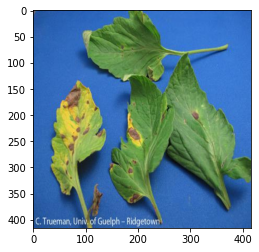

In [41]:
## visualizing input 
img_id = train_id[132]
img = cv2.imread(os.path.join(DIR_INPUT,"train", img_id))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [42]:
target = train_df[train_df['image_id']==img_id]
try:
    center = np.array([target["x"]+target["w"]//2, target["y"]+target["h"]//2]).T
except:
    center = np.array([int(target["x"]+target["w"]//2), int(target["y"]+target["h"]//2)]).T.reshape(1,2)

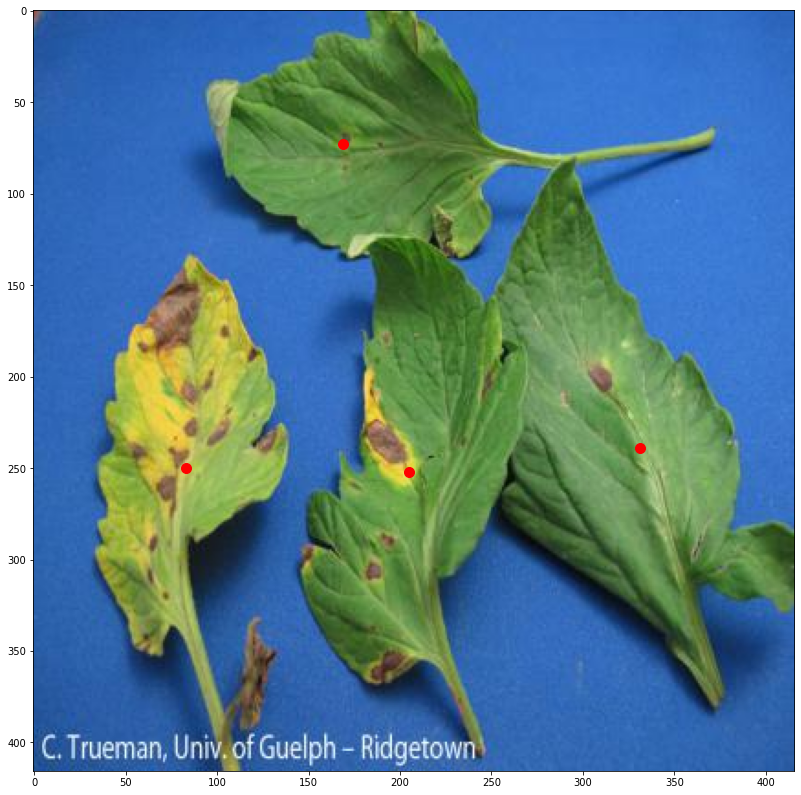

In [43]:
#center point of bounding box
plt.figure(figsize=(14,14))
plt.imshow(img)
for x in center:
    plt.scatter(x[0], x[1], color='red', s=100)

In [44]:
## get gaussian of the image. 
def draw_msra_gaussian(heatmap, center, sigma=2):
  tmp_size = sigma * 6
  mu_x = int(center[0] + 0.5)
  mu_y = int(center[1] + 0.5)
  w, h = heatmap.shape[0], heatmap.shape[1]
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
  if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
    return heatmap
  size = 2 * tmp_size + 1
  x = np.arange(0, size, 1, np.float32)
  y = x[:, np.newaxis]
  x0 = y0 = size // 2
  g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
  g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
  img_x = max(0, ul[0]), min(br[0], h)
  img_y = max(0, ul[1]), min(br[1], w)
  heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
  return heatmap

In [45]:
## get regression output
def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)
  dim = value.shape[0]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value
  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    idx = (masked_gaussian >= masked_heatmap).reshape(
      1, masked_gaussian.shape[0], masked_gaussian.shape[1])
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap
  return regmap


In [46]:
def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

In [47]:
def make_hm_regr(target):
    hm = np.zeros([input_size//MODEL_SCALE, input_size//MODEL_SCALE])
    regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE])
    if len(target) == 0:
        return hm, regr
    try:
        center = np.array([target["x"]+target["w"]//2, target["y"]+target["h"]//2, 
                       target["w"], target["h"]
                      ]).T
    except:
        center = np.array([int(target["x"]+target["w"]//2), int(target["y"]+target["h"]//2), 
                       int(target["w"]), int(target["h"])
                      ]).T.reshape(1,4)
    for c in center:
        hm = draw_msra_gaussian(hm, [int(c[0])//MODEL_SCALE//IN_SCALE, int(c[1])//MODEL_SCALE//IN_SCALE], 
                                sigma=np.clip(c[2]*c[3]//2000, 2, 4))    
    regrs = center[:, 2:]/input_size/IN_SCALE
    for r, c in zip(regrs, center):
        for i in range(-2, 3):
            for j in range(-2, 3):
                try:
                    regr[:, int(c[0])//MODEL_SCALE//IN_SCALE+i, 
                         int(c[1])//MODEL_SCALE//IN_SCALE+j] = r
                except:
                    pass
    regr[0] = regr[0].T; regr[1] = regr[1].T;
    return hm, regr


In [48]:
def pred2box(hm, regr, thresh=0.99):
    pred = hm > thresh
    pred_center = np.where(hm>thresh)
    pred_r = regr[:,pred].T
    boxes = []
    scores = hm[pred]
    for i, b in enumerate(pred_r):
        arr = np.array([pred_center[1][i]*MODEL_SCALE-b[0]*input_size//2, pred_center[0][i]*MODEL_SCALE-b[1]*input_size//2, 
                      int(b[0]*input_size), int(b[1]*input_size)])
        arr = np.clip(arr, 0, input_size)
        boxes.append(arr)
    return np.asarray(boxes), scores


In [49]:
def showbox(img, hm, regr, thresh=0.9):
    boxes, _ = pred2box(hm, regr, thresh=thresh)
    print("preds:",boxes.shape)
    sample = img
    for box in boxes:
        cv2.rectangle(sample,
                      (int(box[0]), int(box[1]+box[3])),
                      (int(box[0]+box[2]), int(box[1])),
                      (220, 0, 0), 1)
    return sample

In [50]:
def showgtbox(img, hm, regr, thresh=0.9):
    boxes, _ = pred2box(hm, regr, thresh=thresh)
    print("GT boxes:", boxes.shape)
    sample = img

    for box in boxes:
        cv2.rectangle(sample,
                      (int(box[0]), int(box[1]+box[3])),
                      (int(box[0]+box[2]), int(box[1])),
                      (0, 220, 0), 1)
    return sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


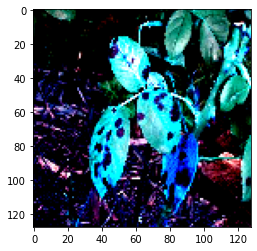

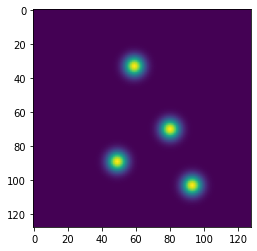

In [51]:
traindataset = WheatDataset(train_id, train_df)
valdataset = WheatDataset(test_id, train_df)
testdataset = WheatDatasetTest('./test')
img, hm, regr = traindataset[100]
plt.imshow(img.transpose([1,2,0]))
plt.show()
img.std()
plt.imshow(hm)

train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(testdataset,batch_size=batch_size,shuffle=False, num_workers=0)

preds: (4, 4)


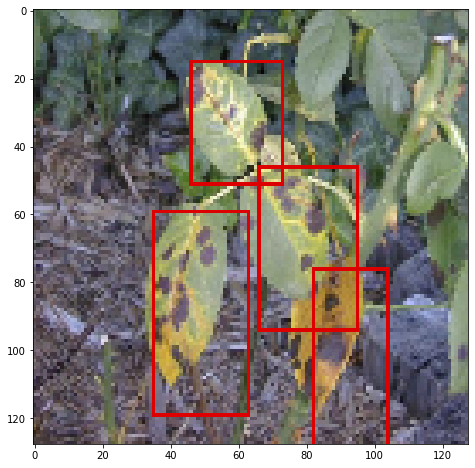

In [52]:
img_id = train_id[100]
img = cv2.imread(os.path.join(DIR_INPUT,"train", img_id))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (input_size, input_size))
sample = img

target = train_df[train_df['image_id']==img_id]
hm, regr = make_hm_regr(target)
boxes, _ = pred2box(hm, regr)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sample = showbox(sample, hm, regr, 0.99)
plt.imshow(sample)
plt.show()

In [53]:
##centernet model
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)
        
    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                            diffY // 2, diffY - diffY//2))
        else:
            x = x1
        x = self.conv(x)
        return x

class centernet(nn.Module):
    def __init__(self, n_classes=1, model_name="resnet18"):
        super(centernet, self).__init__()
        basemodel = torchvision.models.resnet18(pretrained=False) 
        basemodel = nn.Sequential(*list(basemodel.children())[:-2])
        self.base_model = basemodel
        
        if model_name == "resnet34" or model_name=="resnet18":
            num_ch = 512
        else:
            num_ch = 2048
        
        self.up1 = up(num_ch, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 256)
        self.up4 = up(256, 256)
        self.up5 = up(256, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)
        self.outr = nn.Conv2d(256, 2, 1)
        
    def forward(self, x):
        batch_size = x.shape[0]   
        x = self.base_model(x)       
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        x = self.up5(x)
        outc = self.outc(x)
        outr = self.outr(x)
        return outc, outr


In [54]:
model = centernet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [55]:
## calculating different losses
def neg_loss(pred, gt):
  pred = pred.unsqueeze(1).float()
  gt = gt.unsqueeze(1).float()
  pos_inds = gt.eq(1).float()
  neg_inds = gt.lt(1).float()
  neg_weights = torch.pow(1 - gt, 4)
  loss = 0
  pos_loss = torch.log(pred + 1e-12) * torch.pow(1 - pred, 3) * pos_inds
  neg_loss = torch.log(1 - pred + 1e-12) * torch.pow(pred, 3) * neg_weights * neg_inds
  num_pos  = pos_inds.float().sum()
  pos_loss = pos_loss.sum()
  neg_loss = neg_loss.sum()
  if num_pos == 0:
    loss = loss - neg_loss
  else:
    loss = loss - (pos_loss + neg_loss) / num_pos
  return loss

def _reg_loss(regr, gt_regr, mask):
  num = mask.float().sum()
  mask = mask.sum(1).unsqueeze(1).expand_as(gt_regr)
  regr = regr * mask
  gt_regr = gt_regr * mask
    
  regr_loss = nn.functional.smooth_l1_loss(regr, gt_regr, size_average=False)
  regr_loss = regr_loss / (num + 1e-4)
  return regr_loss
  
def centerloss(prediction, mask, regr,weight=0.4, size_average=True):
    pred_mask = torch.sigmoid(prediction[:, 0])
    mask_loss = neg_loss(pred_mask, mask)
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
    loss = mask_loss +regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss

In [56]:
#wandb.watch(model, log_freq=100)

In [57]:
## training
def train(epoch):
    model.train()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_mask = 0.0
    running_regr = 0.0
    t = tqdm(train_loader)
    rd = np.random.rand()
    
    for idx, (img, hm, regr) in enumerate(t):       
        img = img.to(device)
        hm_gt = hm.to(device)
        regr_gt = regr.to(device)
        optimizer.zero_grad()
        hm, regr = model(img)
        preds = torch.cat((hm, regr), 1)
            
        loss, mask_loss, regr_loss = centerloss(preds, hm_gt, regr_gt)
        running_loss += loss
        running_mask += mask_loss
        running_regr += regr_loss
        
        loss.backward()
        optimizer.step()
        
        t.set_description(f't (l={running_loss/(idx+1):.3f})(m={running_mask/(idx+1):.4f})(r={running_regr/(idx+1):.4f})')

    print('train loss : {:.4f}'.format(running_loss/len(train_loader)))
    print('maskloss : {:.4f}'.format(running_mask/(len(train_loader))))
    print('regrloss : {:.4f}'.format(running_regr/(len(train_loader))))
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                    'loss': running_loss/len(train_loader), "mask": running_mask/(len(train_loader)), 
                 "regr": running_regr/(len(train_loader))}
    logs.append(log_epoch)
    #wandb.log(log_epoch)
    



In [58]:
#epochs=100

logs = []
logs_eval = []
length = 0

In [ ]:
logs = []
logs_eval = []

if TRAIN:
    for epoch in range(60,70):
        train(epoch)
else:
    model.load_state_dict(torch.load(MODEL_PATH))


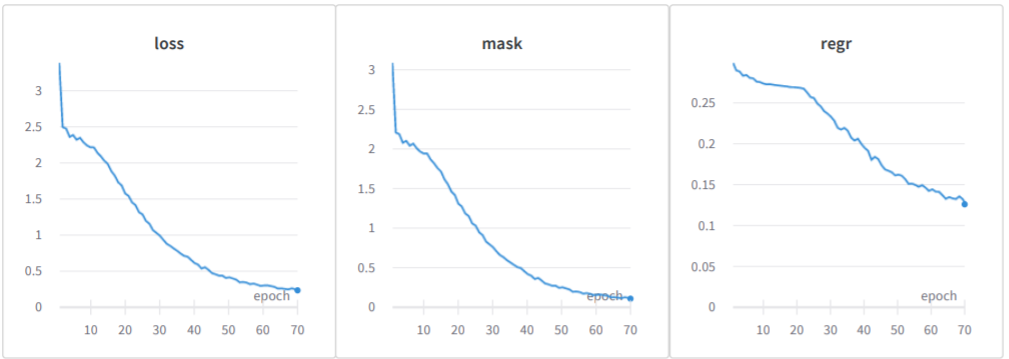

In [61]:
model = torch.load('/content/drive/MyDrive/plant_disease_centernet/plant_disease_model_centernet.pkl').cuda()

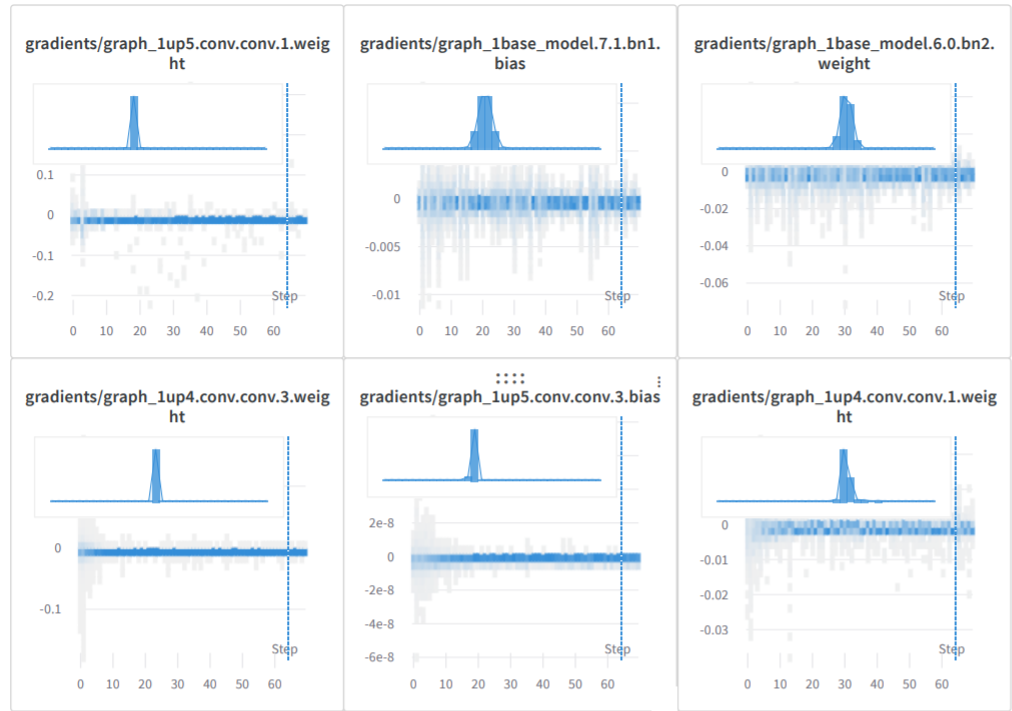

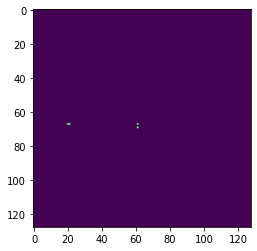

preds: (4, 4)
GT boxes: (1, 4)


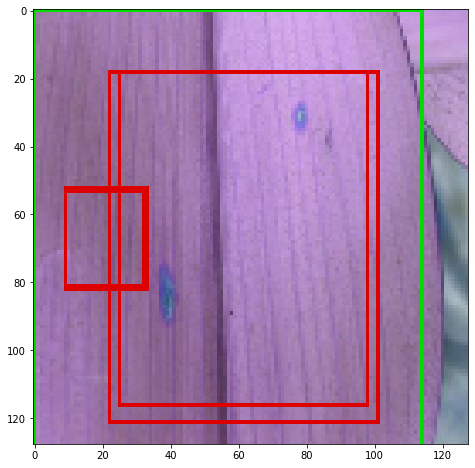

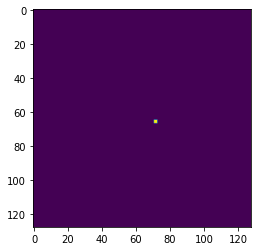

preds: (4, 4)
GT boxes: (1, 4)


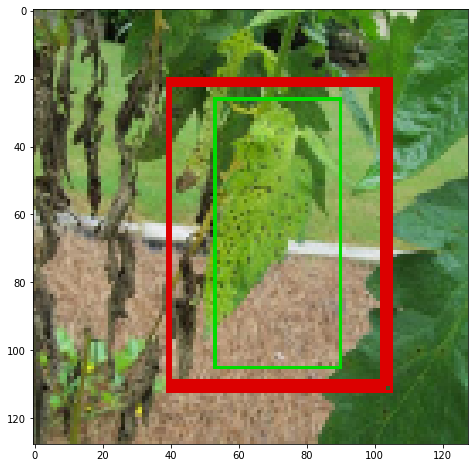

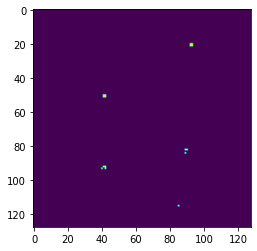

preds: (16, 4)
GT boxes: (6, 4)


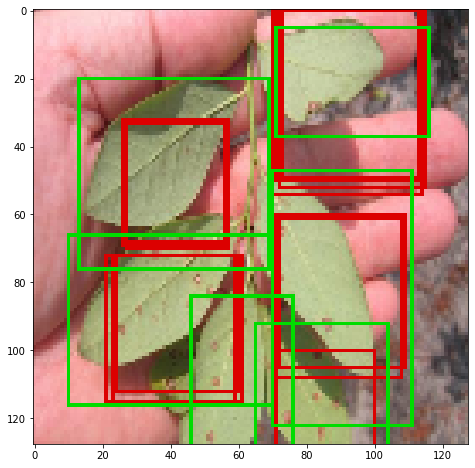

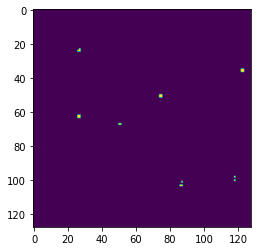

preds: (22, 4)
GT boxes: (8, 4)


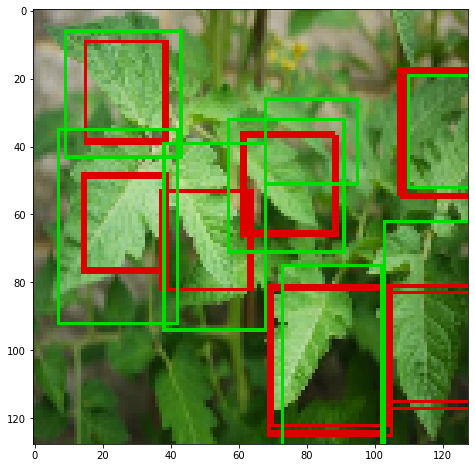

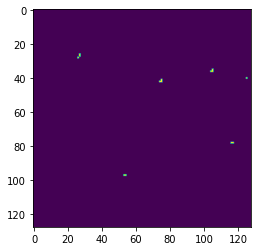

preds: (14, 4)
GT boxes: (15, 4)


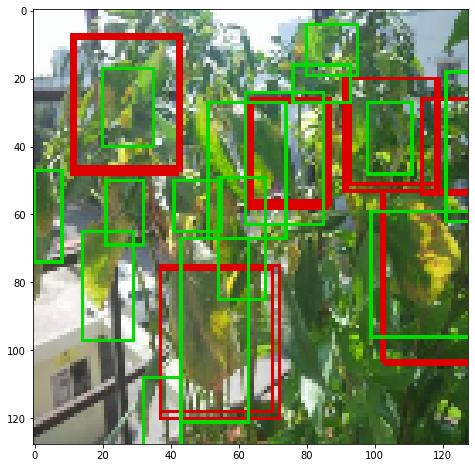

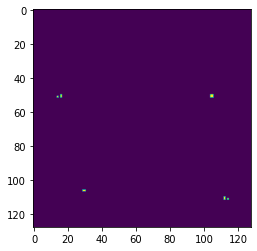

preds: (12, 4)
GT boxes: (5, 4)


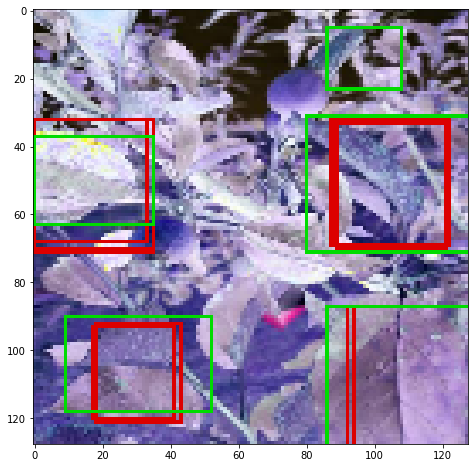

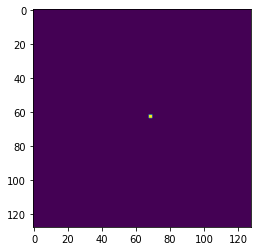

preds: (4, 4)
GT boxes: (1, 4)


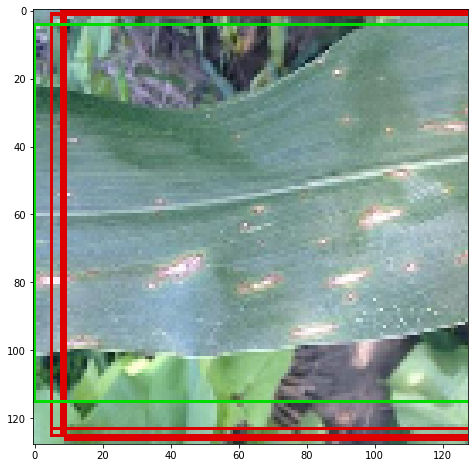

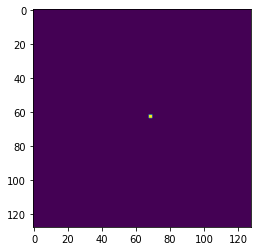

preds: (4, 4)
GT boxes: (1, 4)


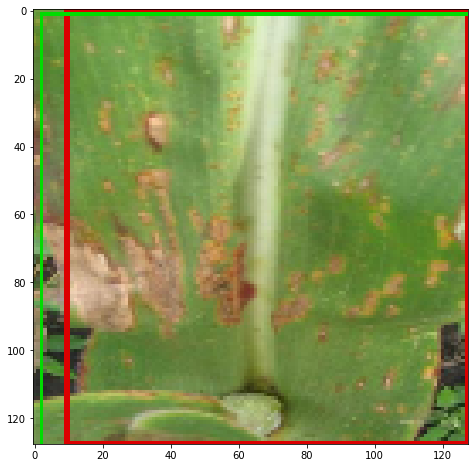

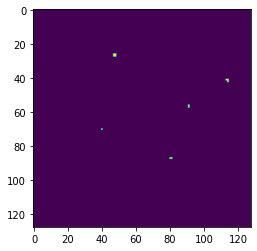

preds: (12, 4)
GT boxes: (8, 4)


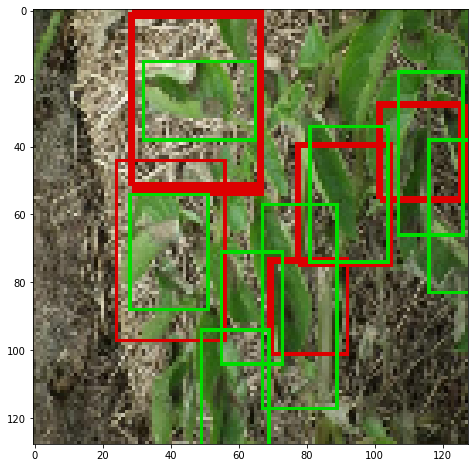

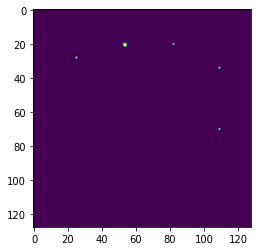

preds: (8, 4)
GT boxes: (7, 4)


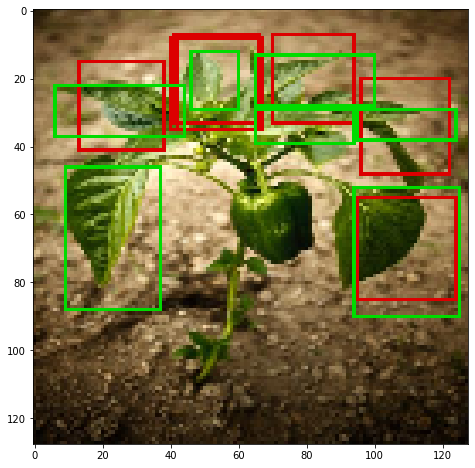

In [62]:
#my_table = wandb.Table()

columns = ['img','gt','predictions']
#test_table = wandb.Table(columns=columns)
imgs_list1 = []
for id in range(10):
    
    img, hm_gt, regr_gt = traindataset[id]
    img = torch.from_numpy(img)
    with torch.no_grad():
        hm, regr = model(img.to(device).float().unsqueeze(0))

    
    hm = hm.cpu().numpy().squeeze(0).squeeze(0)
    regr = regr.cpu().numpy().squeeze(0)

    # show image
    img_id = train_id[id]
    img = cv2.imread(os.path.join(DIR_INPUT,"train", img_id))
    img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (input_size, input_size))
    #temp = wandb.Image(img)
    
    plt.imshow(img)
    # get boxes
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    hm = pool(hm)
    plt.imshow(hm>0.6)##threshold change 
    plt.show()
    sample = showbox(img, hm, regr, 0.6) ##threshold change 
    #temp1 = wandb.Image(hm>0.6)
    # show gt
    sample = showgtbox(sample, hm_gt, regr_gt, 0.99)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.imshow(sample)
    #test_table.add_data(temp,temp1,wandb.Image(sample))
    plt.show()
#wandb.log({"Plant Disease Prediction": test_table})

In [63]:
#torch.save(model,'plant_disease_model_centernet.pkl')

In [64]:

def format_prediction_string(boxes, scores):
    pred_strings = []
    for s, b in zip(scores, boxes.astype(int)):
        pred_strings.append(f'{s:.4f} {b[0]*IN_SCALE} {b[1]*IN_SCALE} {b[2]*IN_SCALE} {b[3]*IN_SCALE}')

    return " ".join(pred_strings)
thresh = 0.6
results = []
for images, image_ids in tqdm(test_loader):
    images = images.to(device)
    with torch.no_grad():
        hms, regrs = model(images)

    for hm, regr, image_id in zip(hms, regrs, image_ids):
        # process predictions
        hm = hm.cpu().numpy().squeeze(0)
        regr = regr.cpu().numpy()
        hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
        hm = pool(hm)

        boxes, scores = pred2box(hm, regr, thresh)

        preds_sorted_idx = np.argsort(scores)[::-1]
        boxes_sorted = boxes[preds_sorted_idx]
        scores_sorted = scores[preds_sorted_idx]
        
        result = {
            'image_id': image_id[:-4],
            'PredictionString': format_prediction_string(boxes, scores)
        }

        results.append(result)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/120 [00:00<?, ?it/s]

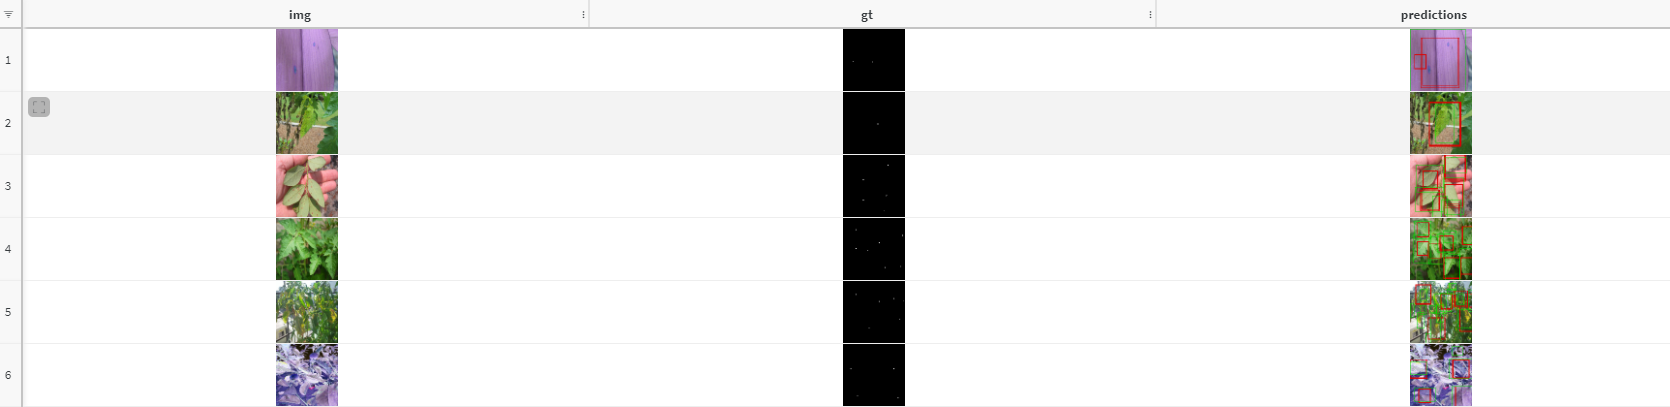

In [65]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])

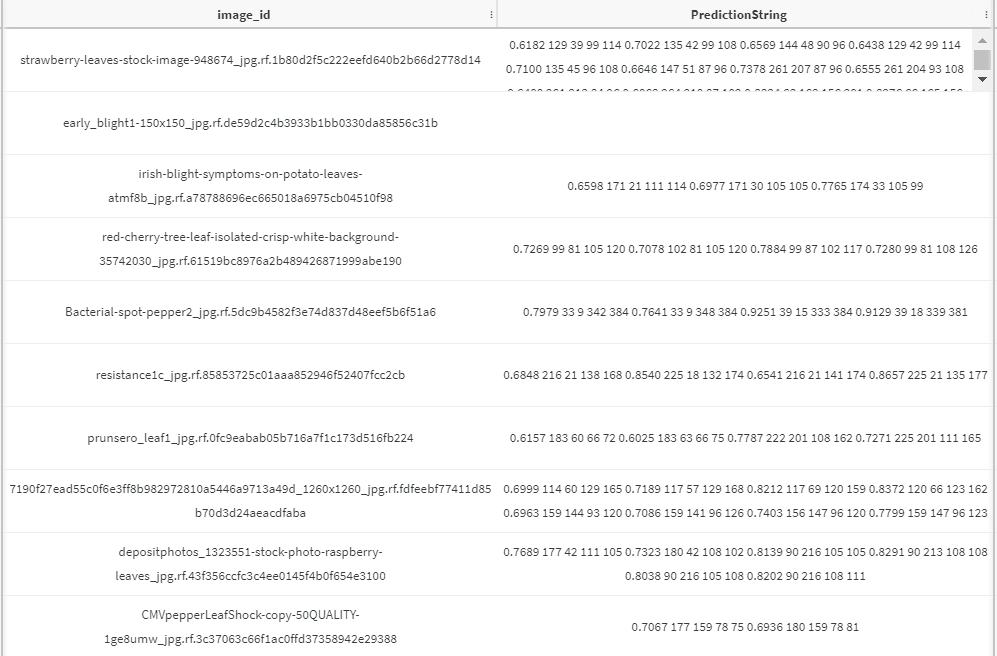